In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb
from numpy import sort
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('/Users/Moli/Documents/InputML/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/Users/Moli/Documents/InputML/santander-customer-transaction-prediction/test.csv')
print("Train: ",train.shape)
print("Test: ", test.shape)

Train:  (200000, 202)
Test:  (200000, 201)


In [31]:
#train.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

In [3]:
#train.corr()

In [4]:
#train.corr()>0.95

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [6]:
target = train.pop('target')
train_ids = train.pop('ID_code')
test_ids = test.pop('ID_code')
len_train = len(train)

In [7]:
y = target.values
X = train
#Train & Validation
from sklearn.model_selection import train_test_split
# create training and testing vars
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(160000, 200) (160000,)
(40000, 200) (40000,)


In [52]:
#Merge test and train
merged = pd.concat([train, test])
#Saving the list of original features in a new list `original_features`.
original_features = merged.columns
merged.shape

(400000, 200)

In [69]:
#merged[["var_1", "var_2"]]

,var_1,var_2
0,-6.7863,11.9081
1,-4.1473,13.8588
2,-2.7457,12.0805
3,-2.1518,8.9522
4,-1.4834,12.8746
5,-2.3182,12.6080
6,-0.0832,9.3494
7,-7.9881,13.8776
8,2.4426,13.9307
9,1.9743,8.8960


In [11]:
#merged.columns
#merged["1v2"] = np.multiply(merged[["var_1"]], merged[["var_2"]]).values
#merged["v"] = np.multiply(merged[["var_"]], merged[["var_"]]).values
#merged["v"] = np.multiply(merged[["var_"]], merged[["var_"]]).values
#merged["v"] = np.multiply(merged[["var_"]], merged[["var_"]]).values
#comb(30, 2)


#merged

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697,2.4354,0.8194,16.5346,12.4205,-0.1

In [12]:
#Getting the list of names of the added features.
new_features = set(merged.columns) - set(original_features)

In [13]:
print("Total number of features: ",merged.shape[1])

Total number of features:  200


In [14]:
train = merged.iloc[:len_train]
X = train
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697,2.4354,0.8194,16.5346,12.4205,-0.1

In [15]:
test = merged.iloc[len_train:]
test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-6.1600,-5.6690,8.9094,

In [16]:
test.iloc[1,]

var_0       8.5304
var_1       1.2543
var_2      11.3047
var_3       5.1858
var_4       9.1974
var_5      -4.0117
var_6       6.0196
var_7      18.6316
var_8      -4.4131
var_9       5.9739
var_10     -1.3809
var_11     -0.3310
var_12     14.1129
var_13      2.5667
var_14      5.4988
var_15     14.1853
var_16      7.0196
var_17      4.6564
var_18     29.1609
var_19      0.0910
var_20     12.1469
var_21      3.1389
var_22      5.2578
var_23      2.4228
var_24     16.2064
var_25     13.5023
var_26     -5.2341
var_27     -3.6648
var_28      5.7080
var_29      2.9965
            ...   
var_170    -0.7720
var_171    -8.1783
var_172    29.9227
var_173    -5.6274
var_174    10.5018
var_175     9.6083
var_176    -0.4935
var_177     8.1696
var_178    -4.3605
var_179     5.2110
var_180     0.4087
var_181    12.0030
var_182   -10.3812
var_183     5.8496
var_184    25.1958
var_185    -8.8468
var_186    11.8263
var_187    -8.7112
var_188    15.9072
var_189     0.9812
var_190    10.6165
var_191     

In [17]:
del merged
gc.collect()

92

In [18]:
params_tuned = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [20]:
%%time
X_test = test.values.astype(float)
y_pred_lgb = np.zeros(len(X_test))
features = [c for c in X.columns]
oof = np.zeros(len(train))
fold_n = 2
cv = fold_n
    
folds = StratifiedKFold(n_splits=fold_n, random_state=10, shuffle=True)

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params_tuned,train_data,num_boost_round=100000,
                valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 1000)
    oof[valid_index] = lgb_model.predict(X.iloc[valid_index][features], num_iteration=lgb_model.best_iteration)
    
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/cv

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

Fold 0 started at Wed Mar 13 08:29:29 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.910037	valid_1's auc: 0.881963
[2000]	training's auc: 0.924197	valid_1's auc: 0.890663
[3000]	training's auc: 0.933544	valid_1's auc: 0.894575
[4000]	training's auc: 0.941096	valid_1's auc: 0.8965
[5000]	training's auc: 0.947323	valid_1's auc: 0.897442
[6000]	training's auc: 0.952834	valid_1's auc: 0.897843
[7000]	training's auc: 0.958047	valid_1's auc: 0.898048
[8000]	training's auc: 0.962715	valid_1's auc: 0.897934
Early stopping, best iteration is:
[7149]	training's auc: 0.958838	valid_1's auc: 0.898065
Fold 1 started at Wed Mar 13 08:34:51 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.910221	valid_1's auc: 0.883145
[2000]	training's auc: 0.923779	valid_1's auc: 0.891135
[3000]	training's auc: 0.932777	valid_1's auc: 0.894727
[4000]	training's auc: 0.940121	valid_1's auc: 0.896576
[5000]	training's auc: 0.

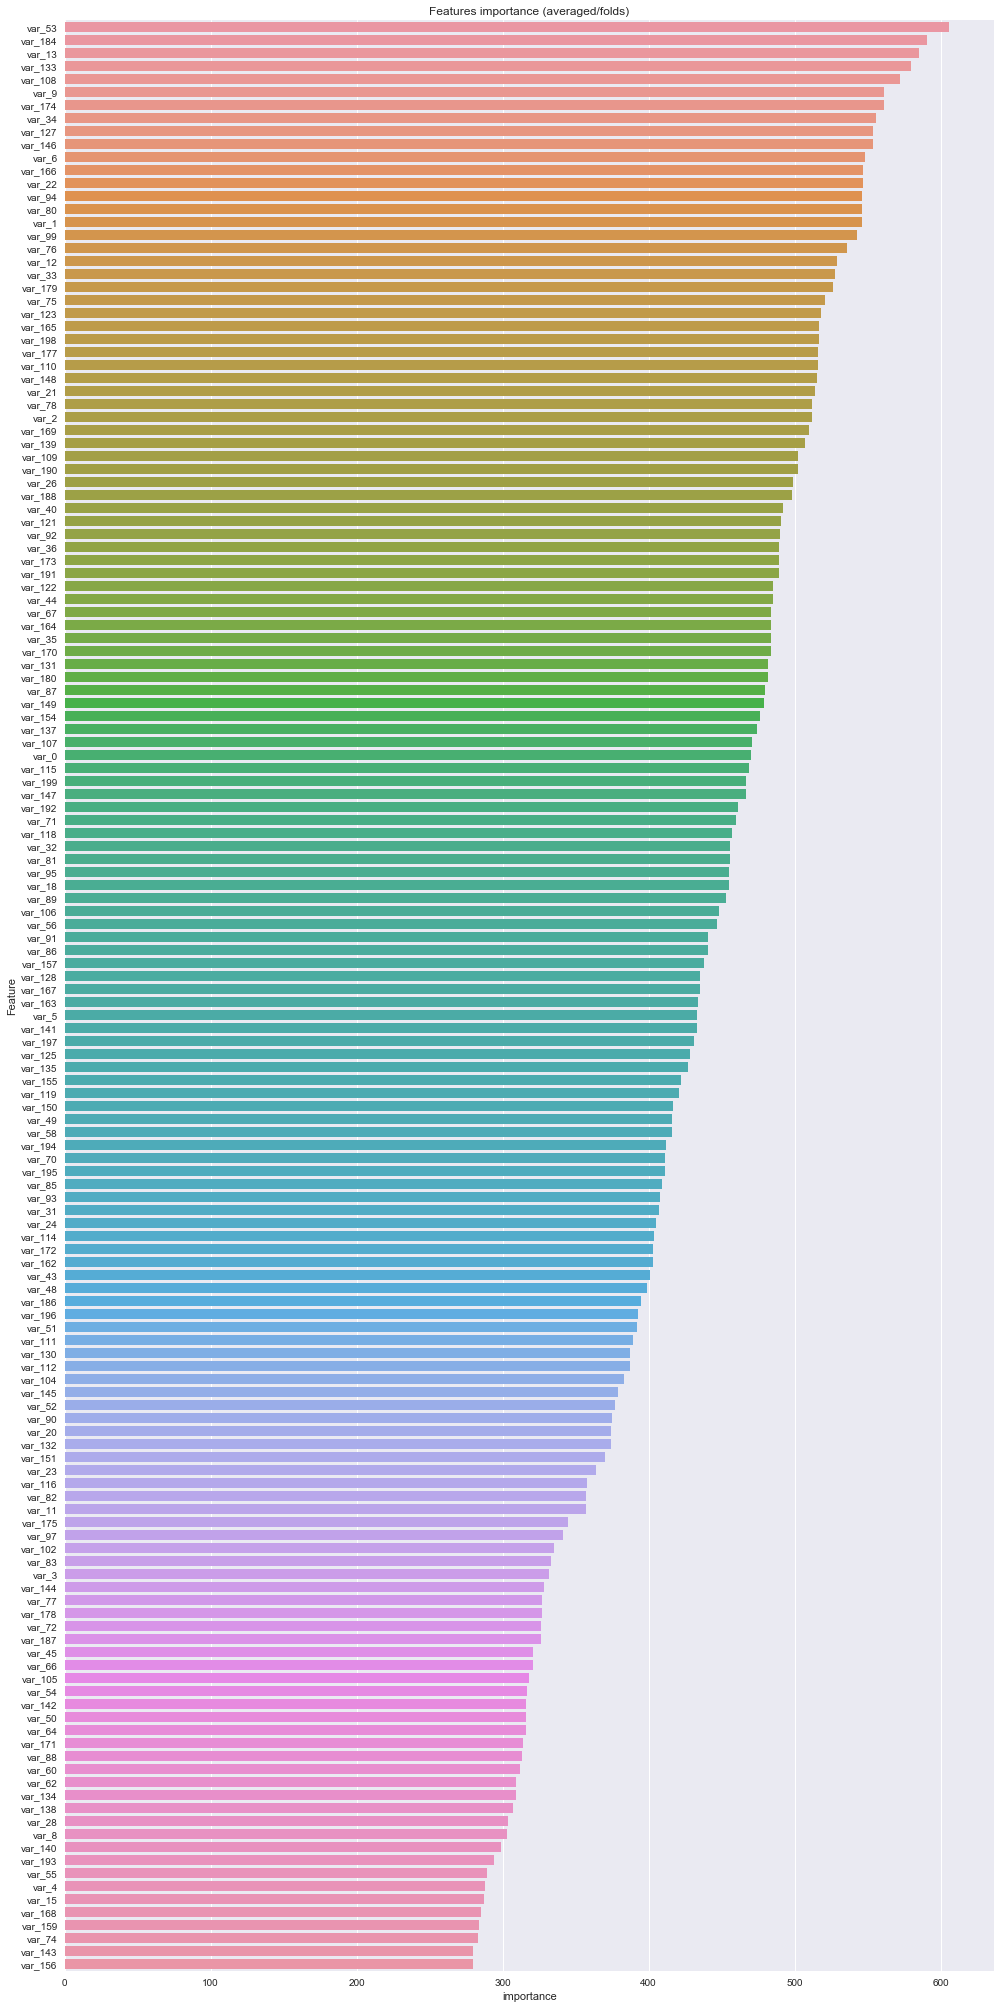

In [21]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [22]:
 from scipy.special import comb, perm

In [24]:
comb(5, 2)

10.0

In [25]:
cols

Index(['var_53', 'var_184', 'var_13', 'var_133', 'var_108', 'var_174', 'var_9',
       'var_34', 'var_146', 'var_127',
       ...
       'var_140', 'var_193', 'var_55', 'var_4', 'var_15', 'var_168', 'var_159',
       'var_74', 'var_143', 'var_156'],
      dtype='object', name='Feature', length=150)

In [83]:
featureind = best_features.sort_values(by="importance",ascending=False)[["Feature"]][:29]

In [84]:
#merged["1v2"] = np.multiply(merged[["var_1"]], merged[["var_2"]]).values

featureind = np.squeeze(featureind)
from itertools import combinations,permutations
a = combinations(featureind, 2)
a

In [47]:
featureind
import itertools
list(itertools.conbinations(featureind))

AttributeError: module 'itertools' has no attribute 'conbinations'

In [71]:
for i in a:
    print(str(i[0]))
    print(str(i[1]))

In [85]:
for i in a:
    print(str(i[0])+ str(i[1]))
    #print(merged[[i[0]]])
    merged[str(i[0]) + '*' + str(i[1])] = np.multiply(merged[[i[0]]], merged[[i[1]]]).values

var_53var_184
var_53var_13
var_53var_133
var_53var_108
var_53var_9
var_53var_174
var_53var_34
var_53var_127
var_53var_146
var_53var_6
var_53var_166
var_53var_22
var_53var_94
var_53var_80
var_53var_1
var_53var_99
var_53var_76
var_53var_12
var_53var_33
var_53var_179
var_53var_75
var_53var_123
var_53var_165
var_53var_198
var_53var_177
var_53var_110
var_53var_148
var_53var_21
var_184var_13
var_184var_133
var_184var_108
var_184var_9
var_184var_174
var_184var_34
var_184var_127
var_184var_146
var_184var_6
var_184var_166
var_184var_22
var_184var_94
var_184var_80
var_184var_1
var_184var_99
var_184var_76
var_184var_12
var_184var_33
var_184var_179
var_184var_75
var_184var_123
var_184var_165
var_184var_198
var_184var_177
var_184var_110
var_184var_148
var_184var_21
var_13var_133
var_13var_108
var_13var_9
var_13var_174
var_13var_34
var_13var_127
var_13var_146
var_13var_6
var_13var_166
var_13var_22
var_13var_94
var_13var_80
var_13var_1
var_13var_99
var_13var_76
var_13var_12
var_13var_33
var_13var_179

In [86]:
merged.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_53*var_184,var_53*var_13,var_53*var_133,var_53*var_108,var_53*var_9,var_53*var_174,var_53*var_34,var_53*var_127,var_53*var_146,var_53*var_6,var_53*var_166,var_53*var_22,var_53*var_94,var_53*var_80,var_53*var_1,var_53*var_99,var_53*var_76,var_53*var_12,var_53*var_33,var_53*var_179,var_53*var_75,var_53*var_123,var_53*var_165,var_53*var_198,var_53*var_177,var_53*var_110,var_53*var_148,var_53*var_21,var_184*var_13,var_184*var_133,var_184*var_108,var_184*var_9,var_184*var_174,var_184*var_34,var_184*var_127,var_184*var_146,var_184*var_6,var_184*var_166,var_184*var_22,var_184*var_94,var_184*var_80,var_184*var_1,var_184*var_99,var_184*var_76,var_184*var_12,var_184*var_33,var_184*var_179,var_184*var_75,var_184*var_123,var_184*var_165,...,var_174*var_6,var_174*var_166,var_174*var_22,var_174*var_94,var_174*var_80,var_174*var_1,var_174*var_99,var_174*var_76,var_174*var_12,var_174*var_33,var_174*var_179,var_174*var_75,var_174*var_123,var_174*var_165,var_174*var_198,var_174*var_177,var_174*var_110,var_174*var_148,var_174*var_21,var_34*var_127,var_34*var_146,var_34*var_6,var_34*var_166,var_34*var_22,var_34*var_94,var_34*var_80,var_34*var_1,var_34*var_99,var_34*var_76,var_34*var_12,var_34*var_33,var_34*var_179,var_34*var_75,var_34*var_123,var_34*var_165,var_34*var_198,var_34*var_177,var_34*var_110,var_34*var_148,var_34*var_21,var_127*var_146,var_127*var_6,var_127*var_166,var_127*var_22,var_127*var_94,var_127*var_80,var_127*var_1,var_127*var_99,var_127*var_76,var_127*var_12,var_127*var_33,var_127*var_179,var_127*var_75,var_127*var_123,var_127*var_165,var_127*var_198,var_127*var_177,var_127*var_110,var_127*var_148,var_127*var_21,var_146*var_6,var_146*var_166,var_146*var_22,var_146*var_94,var_146*var_80,var_146*var_1,var_146*var_99,var_146*var_76,var_146*var_12,var_146*var_33,var_146*var_179,var_146*var_75,var_146*var_123,var_146*var_165,var_146*var_198,var_146*var_177,var_146*var_110,var_146*var_148,var_146*var_21,var_6*var_166,var_6*var_22,var_6*var_94,var_6*var_80,var_6*var_1,var_6*var_99,var_6*var_76,var_6*var_12,var_6*var_33,var_6*var_179,var_6*var_75,var_6*var_123,var_6*var_165,var_6*var_198,var_6*var_177,var_6*var_110,var_6*var_148,var_6*var_21,var_166*var_22,var_166*var_94,var_166*var_80,var_166*var_1,var_166*var_99,var_166*var_76,var_166*var_12,var_166*var_33,var_166*var_179,var_166*var_75,var_166*var_123,var_166*var_165,var_166*var_198,var_166*var_177,var_166*var_110,var_166*var_148,var_166*var_21,var_22*var_94,var_22*var_80,var_22*var_1,var_22*var_99,var_22*var_76,var_

In [87]:
print("Total number of features: ",merged.shape[1])

Total number of features:  606


In [90]:
merged.iloc[:2]

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_53*var_184,var_53*var_13,var_53*var_133,var_53*var_108,var_53*var_9,var_53*var_174,var_53*var_34,var_53*var_127,var_53*var_146,var_53*var_6,var_53*var_166,var_53*var_22,var_53*var_94,var_53*var_80,var_53*var_1,var_53*var_99,var_53*var_76,var_53*var_12,var_53*var_33,var_53*var_179,var_53*var_75,var_53*var_123,var_53*var_165,var_53*var_198,var_53*var_177,var_53*var_110,var_53*var_148,var_53*var_21,var_184*var_13,var_184*var_133,var_184*var_108,var_184*var_9,var_184*var_174,var_184*var_34,var_184*var_127,var_184*var_146,var_184*var_6,var_184*var_166,var_184*var_22,var_184*var_94,var_184*var_80,var_184*var_1,var_184*var_99,var_184*var_76,var_184*var_12,var_184*var_33,var_184*var_179,var_184*var_75,var_184*var_123,var_184*var_165,...,var_174*var_6,var_174*var_166,var_174*var_22,var_174*var_94,var_174*var_80,var_174*var_1,var_174*var_99,var_174*var_76,var_174*var_12,var_174*var_33,var_174*var_179,var_174*var_75,var_174*var_123,var_174*var_165,var_174*var_198,var_174*var_177,var_174*var_110,var_174*var_148,var_174*var_21,var_34*var_127,var_34*var_146,var_34*var_6,var_34*var_166,var_34*var_22,var_34*var_94,var_34*var_80,var_34*var_1,var_34*var_99,var_34*var_76,var_34*var_12,var_34*var_33,var_34*var_179,var_34*var_75,var_34*var_123,var_34*var_165,var_34*var_198,var_34*var_177,var_34*var_110,var_34*var_148,var_34*var_21,var_127*var_146,var_127*var_6,var_127*var_166,var_127*var_22,var_127*var_94,var_127*var_80,var_127*var_1,var_127*var_99,var_127*var_76,var_127*var_12,var_127*var_33,var_127*var_179,var_127*var_75,var_127*var_123,var_127*var_165,var_127*var_198,var_127*var_177,var_127*var_110,var_127*var_148,var_127*var_21,var_146*var_6,var_146*var_166,var_146*var_22,var_146*var_94,var_146*var_80,var_146*var_1,var_146*var_99,var_146*var_76,var_146*var_12,var_146*var_33,var_146*var_179,var_146*var_75,var_146*var_123,var_146*var_165,var_146*var_198,var_146*var_177,var_146*var_110,var_146*var_148,var_146*var_21,var_6*var_166,var_6*var_22,var_6*var_94,var_6*var_80,var_6*var_1,var_6*var_99,var_6*var_76,var_6*var_12,var_6*var_33,var_6*var_179,var_6*var_75,var_6*var_123,var_6*var_165,var_6*var_198,var_6*var_177,var_6*var_110,var_6*var_148,var_6*var_21,var_166*var_22,var_166*var_94,var_166*var_80,var_166*var_1,var_166*var_99,var_166*var_76,var_166*var_12,var_166*var_33,var_166*var_179,var_166*var_75,var_166*var_123,var_166*var_165,var_166*var_198,var_166*var_177,var_166*var_110,var_166*var_148,var_166*var_21,var_22*var_94,var_22*var_80,var_22*var_1,var_22*var_99,var_22*var_76,var_

In [88]:
len_train

200000

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_53*var_184,var_53*var_13,var_53*var_133,var_53*var_108,var_53*var_9,var_53*var_174,var_53*var_34,var_53*var_127,var_53*var_146,var_53*var_6,var_53*var_166,var_53*var_22,var_53*var_94,var_53*var_80,var_53*var_1,var_53*var_99,var_53*var_76,var_53*var_12,var_53*var_33,var_53*var_179,var_53*var_75,var_53*var_123,var_53*var_165,var_53*var_198,var_53*var_177,var_53*var_110,var_53*var_148,var_53*var_21,var_184*var_13,var_184*var_133,var_184*var_108,var_184*var_9,var_184*var_174,var_184*var_34,var_184*var_127,var_184*var_146,var_184*var_6,var_184*var_166,var_184*var_22,var_184*var_94,var_184*var_80,var_184*var_1,var_184*var_99,var_184*var_76,var_184*var_12,var_184*var_33,var_184*var_179,var_184*var_75,var_184*var_123,var_184*var_165,...,var_174*var_6,var_174*var_166,var_174*var_22,var_174*var_94,var_174*var_80,var_174*var_1,var_174*var_99,var_174*var_76,var_174*var_12,var_174*var_33,var_174*var_179,var_174*var_75,var_174*var_123,var_174*var_165,var_174*var_198,var_174*var_177,var_174*var_110,var_174*var_148,var_174*var_21,var_34*var_127,var_34*var_146,var_34*var_6,var_34*var_166,var_34*var_22,var_34*var_94,var_34*var_80,var_34*var_1,var_34*var_99,var_34*var_76,var_34*var_12,var_34*var_33,var_34*var_179,var_34*var_75,var_34*var_123,var_34*var_165,var_34*var_198,var_34*var_177,var_34*var_110,var_34*var_148,var_34*var_21,var_127*var_146,var_127*var_6,var_127*var_166,var_127*var_22,var_127*var_94,var_127*var_80,var_127*var_1,var_127*var_99,var_127*var_76,var_127*var_12,var_127*var_33,var_127*var_179,var_127*var_75,var_127*var_123,var_127*var_165,var_127*var_198,var_127*var_177,var_127*var_110,var_127*var_148,var_127*var_21,var_146*var_6,var_146*var_166,var_146*var_22,var_146*var_94,var_146*var_80,var_146*var_1,var_146*var_99,var_146*var_76,var_146*var_12,var_146*var_33,var_146*var_179,var_146*var_75,var_146*var_123,var_146*var_165,var_146*var_198,var_146*var_177,var_146*var_110,var_146*var_148,var_146*var_21,var_6*var_166,var_6*var_22,var_6*var_94,var_6*var_80,var_6*var_1,var_6*var_99,var_6*var_76,var_6*var_12,var_6*var_33,var_6*var_179,var_6*var_75,var_6*var_123,var_6*var_165,var_6*var_198,var_6*var_177,var_6*var_110,var_6*var_148,var_6*var_21,var_166*var_22,var_166*var_94,var_166*var_80,var_166*var_1,var_166*var_99,var_166*var_76,var_166*var_12,var_166*var_33,var_166*var_179,var_166*var_75,var_166*var_123,var_166*var_165,var_166*var_198,var_166*var_177,var_166*var_110,var_166*var_148,var_166*var_21,var_22*var_94,var_22*var_80,var_22*var_1,var_22*var_99,var_22*var_76,var_

In [92]:
test = merged.iloc[len_train:]
test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_53*var_184,var_53*var_13,var_53*var_133,var_53*var_108,var_53*var_9,var_53*var_174,var_53*var_34,var_53*var_127,var_53*var_146,var_53*var_6,var_53*var_166,var_53*var_22,var_53*var_94,var_53*var_80,var_53*var_1,var_53*var_99,var_53*var_76,var_53*var_12,var_53*var_33,var_53*var_179,var_53*var_75,var_53*var_123,var_53*var_165,var_53*var_198,var_53*var_177,var_53*var_110,var_53*var_148,var_53*var_21,var_184*var_13,var_184*var_133,var_184*var_108,var_184*var_9,var_184*var_174,var_184*var_34,var_184*var_127,var_184*var_146,var_184*var_6,var_184*var_166,var_184*var_22,var_184*var_94,var_184*var_80,var_184*var_1,var_184*var_99,var_184*var_76,var_184*var_12,var_184*var_33,var_184*var_179,var_184*var_75,var_184*var_123,var_184*var_165,...,var_174*var_6,var_174*var_166,var_174*var_22,var_174*var_94,var_174*var_80,var_174*var_1,var_174*var_99,var_174*var_76,var_174*var_12,var_174*var_33,var_174*var_179,var_174*var_75,var_174*var_123,var_174*var_165,var_174*var_198,var_174*var_177,var_174*var_110,var_174*var_148,var_174*var_21,var_34*var_127,var_34*var_146,var_34*var_6,var_34*var_166,var_34*var_22,var_34*var_94,var_34*var_80,var_34*var_1,var_34*var_99,var_34*var_76,var_34*var_12,var_34*var_33,var_34*var_179,var_34*var_75,var_34*var_123,var_34*var_165,var_34*var_198,var_34*var_177,var_34*var_110,var_34*var_148,var_34*var_21,var_127*var_146,var_127*var_6,var_127*var_166,var_127*var_22,var_127*var_94,var_127*var_80,var_127*var_1,var_127*var_99,var_127*var_76,var_127*var_12,var_127*var_33,var_127*var_179,var_127*var_75,var_127*var_123,var_127*var_165,var_127*var_198,var_127*var_177,var_127*var_110,var_127*var_148,var_127*var_21,var_146*var_6,var_146*var_166,var_146*var_22,var_146*var_94,var_146*var_80,var_146*var_1,var_146*var_99,var_146*var_76,var_146*var_12,var_146*var_33,var_146*var_179,var_146*var_75,var_146*var_123,var_146*var_165,var_146*var_198,var_146*var_177,var_146*var_110,var_146*var_148,var_146*var_21,var_6*var_166,var_6*var_22,var_6*var_94,var_6*var_80,var_6*var_1,var_6*var_99,var_6*var_76,var_6*var_12,var_6*var_33,var_6*var_179,var_6*var_75,var_6*var_123,var_6*var_165,var_6*var_198,var_6*var_177,var_6*var_110,var_6*var_148,var_6*var_21,var_166*var_22,var_166*var_94,var_166*var_80,var_166*var_1,var_166*var_99,var_166*var_76,var_166*var_12,var_166*var_33,var_166*var_179,var_166*var_75,var_166*var_123,var_166*var_165,var_166*var_198,var_166*var_177,var_166*var_110,var_166*var_148,var_166*var_21,var_22*var_94,var_22*var_80,var_22*var_1,var_22*var_99,var_22*var_76,var_

In [97]:
np.squeeze(featureind.values)

Fold 0 started at Wed Mar 13 09:55:27 2019
[1000]	training's auc: 0.818439	valid_1's auc: 0.797003
[2000]	training's auc: 0.858537	valid_1's auc: 0.833005
[3000]	training's auc: 0.883366	valid_1's auc: 0.853223
[4000]	training's auc: 0.901036	valid_1's auc: 0.866859
[5000]	training's auc: 0.911991	valid_1's auc: 0.874862
[6000]	training's auc: 0.920232	valid_1's auc: 0.879851
[7000]	training's auc: 0.927071	valid_1's auc: 0.883817
[8000]	training's auc: 0.932452	valid_1's auc: 0.886432
[9000]	training's auc: 0.937368	valid_1's auc: 0.888536
[10000]	training's auc: 0.941513	valid_1's auc: 0.890128
[11000]	training's auc: 0.945713	valid_1's auc: 0.891356
[12000]	training's auc: 0.949423	valid_1's auc: 0.892242
[13000]	training's auc: 0.952818	valid_1's auc: 0.893044
[14000]	training's auc: 0.955949	valid_1's auc: 0.893659


KeyboardInterrupt: 